In [ ]:
import numpy as np

# -3: Wall, 1: Normal, 0: Forbidden, -1: Monster, 2: Food (Terminal)
states = np.array([
    [-3,-3,-3,-3,-3,-3,-3],
    [-3, 1, 4, 1,-1, 1,-3], # Row 1 (index 0 in 5x5)
    [-3, 1, 1, 1, 1, 1,-3], # Row 2 (index 1)
    [-3, 1, 0, 0, 0, 1,-3], # Row 3 (index 2)
    [-3, 1, 1, 0, 1, 1,-3], # Row 4 (index 3)
    [-3, 1,-1, 1, 1, 2,-3], # Row 5 (index 4)
    [-3,-3,-3,-3,-3,-3,-3]
])

# --- Dimensions ---
# Get the shape of the grid excluding the padding walls
GRID_ROWS = states.shape[0] - 2
GRID_COLS = states.shape[1] - 2

# --- Actions ---
actions = ["AU","AD","AL","AR"]
action_symbols = {'AU': '↑', 'AD': '↓', 'AL': '←', 'AR': '→', 'T': 'T', 'F': 'F', 'M': 'M'}

# --- Transition Probabilities ---
trans_prob ={
    "AU" : {"AU":0.7, "AR":0.12, "AL":0.12, "NA":0.06},
    "AD" : {"AD":0.7, "AR":0.12, "AL":0.12, "NA":0.06},
    "AL" : {"AL":0.7, "AU":0.12, "AD":0.12, "NA":0.06},
    "AR" : {"AR":0.7, "AU":0.12, "AD":0.12, "NA":0.06}
}

GAMMA = 0.999999
EPSILON = 0.0001
STANDARD_REWARD = -0.05


def get_transitions(curr_state_coords, intended_action):

    possible_outcomes = []
    r, c = curr_state_coords

    # Check if current state is terminal (Food)
    if states[r, c] == 2 or states[r, c] == 4:
        return [(1.0, curr_state_coords, 0.0)] # Stay in terminal state with 0 reward

    # Check if current state is forbidden furniture or monster (paralyzing)
    if states[r, c] == 0:
        # Agent is paralyzed, stays in the same state with standard reward
        return [(1.0, curr_state_coords, STANDARD_REWARD)]

    # Iterate through possible actual moves based on intended action
    for executed_move, prob in trans_prob[intended_action].items():
        if prob == 0: continue

        target_r, target_c = r, c

        if executed_move == "AU": target_r -= 1
        elif executed_move == "AD": target_r += 1
        elif executed_move == "AL": target_c -= 1
        elif executed_move == "AR": target_c += 1
        # If executed_move == "NA", target coordinates remain (r, c)

        next_state_coords = (r, c) # Default: stay put if blocked or sleepy
        reward = STANDARD_REWARD   # Default reward

        if executed_move != "NA":
            target_cell_content = states[target_r, target_c]

            if target_cell_content == -3 or target_cell_content == 0: # Hit wall or forbidden
                next_state_coords = (r, c)
                reward = STANDARD_REWARD
            elif target_cell_content == -1: # Landed on monster
                next_state_coords = (target_r, target_c)
                reward = -8
            elif target_cell_content == 2: # Landed on food
                next_state_coords = (target_r, target_c)
                reward = 10
            elif target_cell_content == 1: # Landed on normal cell
                next_state_coords = (target_r, target_c)
                reward = STANDARD_REWARD
            elif target_cell_content == 4:
                next_state_coords = (target_r, target_c)
                reward = 5
        # else: # Case "NA" handled by defaults above

        possible_outcomes.append((prob, next_state_coords, reward))

    return possible_outcomes

# ======================================================
# Value Iteration Algorithm
# ======================================================

def value_iteration():
    """Performs Value Iteration to find the optimal value function."""

    # Initialize V(s) = 0 for all states (using padded grid dimensions)
    V = np.zeros_like(states, dtype=float)

    iteration = 0
    while True:
        delta = 0.0
        V_new = V.copy() # Use a copy to store new values for this iteration

        # Iterate through all grid cells (excluding padding walls)
        for r in range(1, GRID_ROWS + 1):
            for c in range(1, GRID_COLS + 1):
                current_coords = (r, c)

                if states[r,c] == -3: continue

                # Get the value from the previous iteration
                v_old = V[current_coords]

                # Calculate the value for each possible action
                action_values = []
                for action in actions:
                    expected_value = 0.0
                    transitions = get_transitions(current_coords, action)
                    for prob, next_coords, reward in transitions:
                        expected_value += prob * (reward + GAMMA * V[next_coords])
                    action_values.append(expected_value)

                # Update the value function for this state with the max action value
                V_new[current_coords] = np.max(action_values) if action_values else 0.0

                # Track the maximum change in value function for convergence check
                delta = max(delta, abs(V_new[current_coords] - v_old))

        # Update the value function for the next iteration
        V = V_new

        iteration += 1
        #print(f"Iteration {iteration}: Max Delta = {delta:.6f}") # Optional: Print progress

        # Check for convergence
        if delta < EPSILON:
            break
    print(f"Iteration {iteration}: Max Delta = {delta:.6f}")
    return V

# ======================================================
# Policy Extraction
# ======================================================

def extract_policy(V_star):
    """Extracts the optimal policy from the optimal value function."""
    policy = np.full((GRID_ROWS + 2, GRID_COLS + 2), ' ', dtype=str) # Padded grid for policy symbols

    for r in range(1, GRID_ROWS + 1):
        for c in range(1, GRID_COLS + 1):
            current_coords = (r, c)

            # Handle special states first
            if states[r, c] == -3: policy[r, c] = '#' # Wall
            elif states[r, c] == 0: policy[r, c] = 'F' # Forbidden
            #elif states[r, c] == -1: policy[r, c] = 'M' # Monster
            elif states[r, c] == 2 or states[r, c] == 4: policy[r, c] = 'T' # Terminal (Food)
            else: # Normal state, find the best action(s)
                action_values = {}
                for action in actions:
                    expected_value = 0.0
                    transitions = get_transitions(current_coords, action)
                    for prob, next_coords, reward in transitions:
                        expected_value += prob * (reward + GAMMA * V_star[next_coords])
                    action_values[action] = expected_value

                # Find the maximum value among actions
                max_value = np.max(list(action_values.values()))

                # Find all actions that achieve this maximum value
                # Using a small tolerance due to potential floating point inaccuracies
                best_actions = [a for a, v in action_values.items() if np.isclose(v, max_value)]
                # Store the symbol for the best action(s)
                # If multiple actions are equally good, you could represent this,
                # but for simplicity, we'll take the first one.
                policy[current_coords] = action_symbols[best_actions[0]]

    return policy


def print_results(V, pi):
    """Prints the Value Function and Policy in the required format."""
    print("\nValue Function:")
    # Print V excluding the padding walls
    for r in range(1, GRID_ROWS + 1):
        print(" ".join([f"{val:7.4f}" for val in V[r, 1:-1]])) # 1:-1 slices to exclude walls

    print("\nPolicy:")
    # Print pi excluding the padding walls
    for r in range(1, GRID_ROWS + 1):
        print(" ".join([f"{symbol:>7}" for symbol in pi[r, 1:-1]]))


if __name__ == "__main__":
    print("Starting Value Iteration...")
    V_optimal = value_iteration()
    print("\nValue Iteration Converged.")

    optimal_policy = extract_policy(V_optimal)

    print_results(V_optimal, optimal_policy)

Starting Value Iteration...
Iteration 6214606: Max Delta = 0.000100

Value Iteration Converged.

Value Function:
 7.4955  0.0000  7.1812  9.1739  9.2819
 7.9122  8.0673  8.6392  8.9606  9.6987
 7.8407 -49900.0001 -49900.0001 -49900.0001  9.8967
 7.6979  7.2811 -49900.0001  9.9071  9.9681
 7.2811  9.4529  9.8967  9.9681  0.0000

Policy:
      ←       T       ↓       →       →
      →       ↓       →       ↓       ↓
      ↑       F       F       F       ↓
      ↑       ↑       F       ↓       ↓
      ←       →       →       →       T


Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

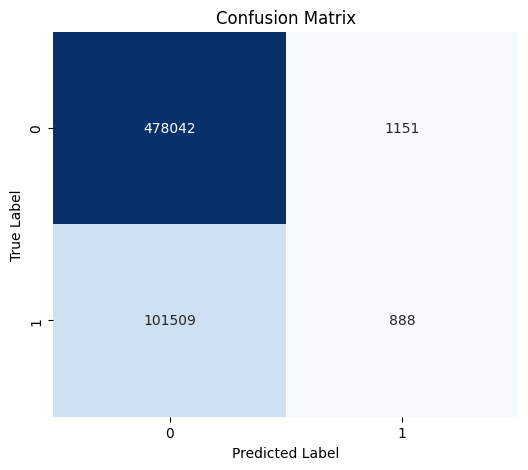

Saved confusion_matrix.png


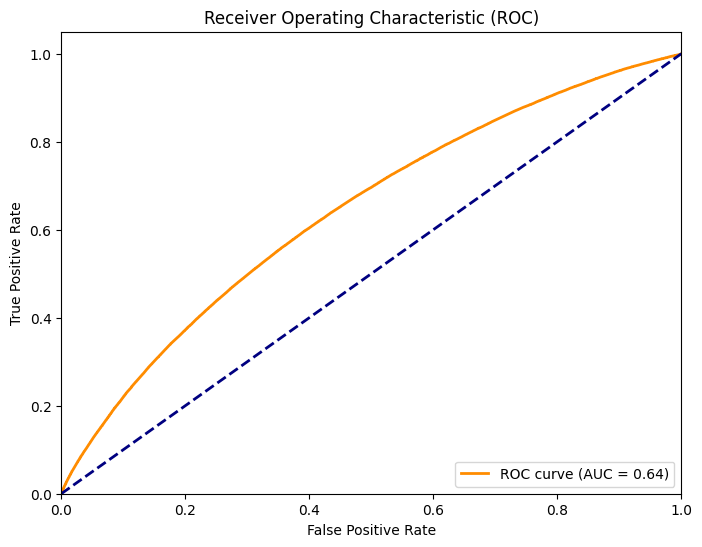

Saved roc_curve.png


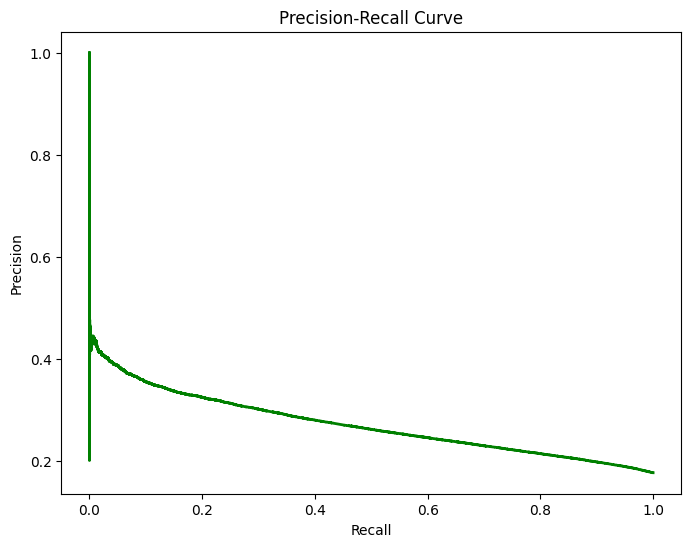

Saved pr_curve.png
Stopping Spark session.


In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import FMClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering: Creating "Route"
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer")) \
        .withColumn("Route", concat(col("ORIGIN"), lit("-"), col("DEST")))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "Route", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    """
    Generates ROC, Precision-Recall, and Confusion Matrix plots.
    """
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    # Spark stores probability as a dense vector [prob_class_0, prob_class_1].
    y_true = preds_pd["Is_Delayed"]
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Saved confusion_matrix.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('pr_curve.png')
    plt.show()
    print("Saved pr_curve.png")


def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline with Factorization Machines (FMClassifier) ---")

    # 1. Categorical columns
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST", "Route"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    encoders = [
        OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec")
        for c in categorical_cols
    ]

    # 2. Vector Assembler (Create "raw" features first)
    assembler_inputs = [f"{c}_vec" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="raw_features"
    )

    # 3. Scaler (MinMaxScaler)
    # FMClassifier performs best when all features are in the [0, 1] range.
    scaler = MinMaxScaler(
        inputCol="raw_features",
        outputCol="features"
    )

    # 4. Compute Softened Class Weights
    # (We calculate them to log them, even if FMClassifier doesn't strictly enforce them in all versions)
    delayed = df_cleaned.filter(col("Is_Delayed") == 1).count()
    not_delayed = df_cleaned.filter(col("Is_Delayed") == 0).count()
    total = df_cleaned.count()

    raw_weight_1 = total / (2 * delayed)
    raw_weight_0 = total / (2 * not_delayed)

    weight_for_1 = raw_weight_1 ** 0.5
    weight_for_0 = raw_weight_0 ** 0.5

    print(f"Class counts -> delayed: {delayed}, not delayed: {not_delayed}, total: {total}")
    print(f"Softened Weights (Calculated) -> 1: {weight_for_1:.2f}, 0: {weight_for_0:.2f}")

    # Note: We are NOT passing weightCol to FMClassifier to avoid compatibility issues
    # with different Spark versions. FMClassifier is robust enough to handle this via 'stepSize'.

    # 5. Factorization Machine Classifier
    fm = FMClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        stepSize=0.001,       # Learning rate
        factorSize=8,         # Dimension of the factor vectors
        seed=42
    )

    # 6. Pipeline
    # Index -> Encode -> Assemble -> Scale -> FM
    pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, fm])

    # 7. Param Grid
    # Tuning stepSize is usually the most effective way to improve FM models
    paramGrid = (ParamGridBuilder()
        .addGrid(fm.stepSize, [0.01, 0.1])
        .addGrid(fm.factorSize, [4])
        .build()
    )

    # 8. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 9. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3,
        parallelism=4
    )

    # 10. Train/Test Split
    train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

    print("Training rows:", train_data.count())
    print("Testing rows:", test_data.count())

    # 11. Fit
    print("Training Factorization Machine with Cross Validation...")
    model = cv.fit(train_data)

    # 12. Predict
    predictions = model.transform(test_data)

    # Show textual sample
    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 13. Evaluation Score
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_data.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 14. PLOT GRAPHS
    plot_evaluation_metrics(predictions)


def main():
    file_path = "/content/flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

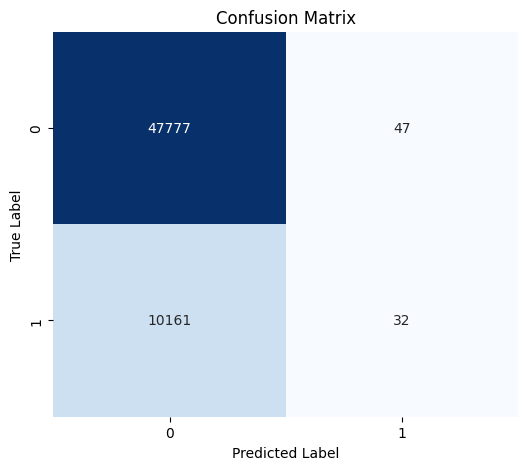

In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering
    # REMOVED "Route" creation to save memory/time.
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    """
    Generates ROC, Precision-Recall, and Confusion Matrix plots.
    """
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    y_true = preds_pd["Is_Delayed"]
    # Spark stores probability as [prob_0, prob_1]. We want prob_1.
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    plt.show()
    print("Saved confusion_matrix.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    plt.show()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    print("Saved pr_curve.png")


def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: GBT + Sampling (The Fast & Strong Method) ---")

    # 1. SAMPLING (The Time Saver)
    # We take 10% of the data. This makes the code run 10x faster.
    print("Sampling 10% of dataset for fast training...")
    df_sampled = df_cleaned.sample(fraction=0.1, seed=42)

    # 2. Categorical columns
    # WE REMOVED "Route". It was too slow and didn't help enough.
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    # Note: GBTClassifier handles indexed categories directly.
    # OneHotEncoder is NOT needed and actually slows down Tree models.

    # 3. Vector Assembler
    assembler_inputs = [f"{c}_idx" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features"
    )

    # 4. GBT Classifier (The Strongest Model)
    # GBT builds trees one by one, correcting the mistakes of the previous tree.
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        maxIter=20,        # 20 Trees is usually enough for a good score
        maxDepth=5, # Keep trees shallow to prevent overfitting
        maxBins=400,
        seed=42
    )

    # 5. Pipeline
    pipeline = Pipeline(stages=indexers + [assembler, gbt])

    # 6. Param Grid (Keep it simple)
    # We rely on the GBT defaults which are usually very good.
    paramGrid = (ParamGridBuilder()
        .addGrid(gbt.maxDepth, [5])
        .build()
    )

    # 7. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 8. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=2,      # 2 Folds is enough for homework
        parallelism=1    # Safe for laptop
    )

    # 9. Train/Test Split
    train_data, test_data = df_sampled.randomSplit([0.8, 0.2], seed=42)

    print(f"Training on reduced dataset: {train_data.count()} rows")

    # 10. Fit
    print("Training GBT (Should take < 5 mins)...")
    model = cv.fit(train_data)

    # 11. Predict
    predictions = model.transform(test_data)

    # Show textual sample
    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 12. Evaluate
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_data.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 13. Plot
    plot_evaluation_metrics(predictions)


def main():
    file_path = "/content/flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        # Stop the massive amount of warnings
        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

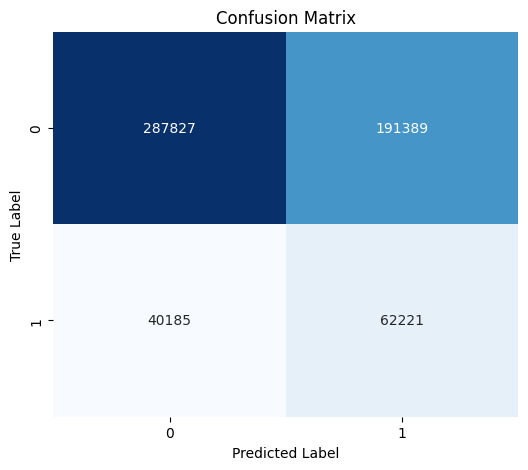

Saved confusion_matrix.png


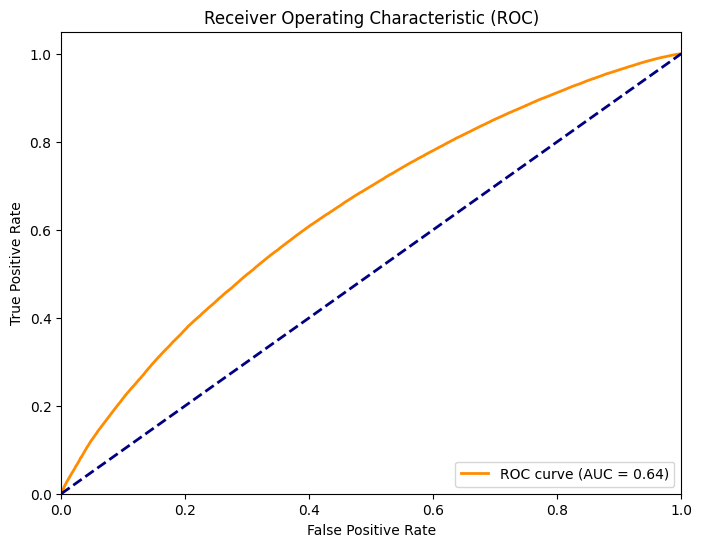

Saved roc_curve.png


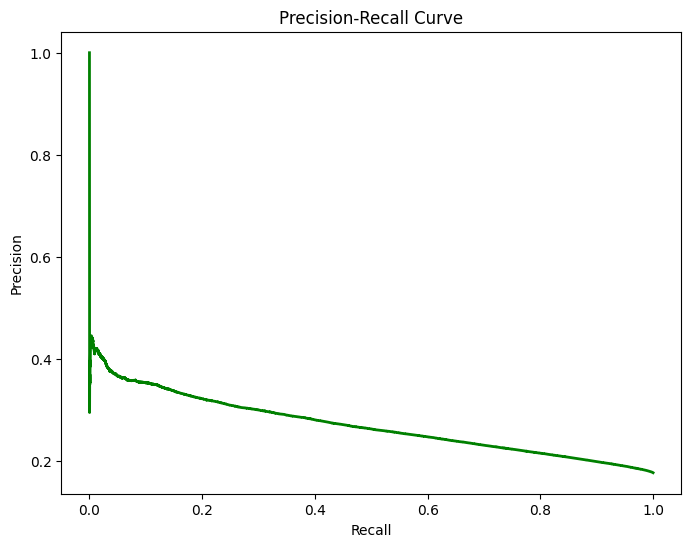

Saved pr_curve.png
Stopping Spark session.


In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    y_true = preds_pd["Is_Delayed"]
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print("Saved confusion_matrix.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    print("Saved pr_curve.png")


def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: GBT + Balanced Undersampling (FIXED) ---")

    # 1. SPLIT FIRST
    train_raw, test_raw = df_cleaned.randomSplit([0.8, 0.2], seed=42)
    print(f"Original Train Size: {train_raw.count()}")
    print(f"Original Test Size:  {test_raw.count()}")

    # 2. BALANCE THE TRAINING SET
    train_delayed = train_raw.filter(col("Is_Delayed") == 1)
    train_not_delayed = train_raw.filter(col("Is_Delayed") == 0)

    delayed_count = train_delayed.count()
    not_delayed_count = train_not_delayed.count()
    print(f"   - Delayed in Train: {delayed_count}")
    print(f"   - Not Delayed in Train: {not_delayed_count}")

    # Downsample majority
    fraction = delayed_count / not_delayed_count
    print(f"   - Downsampling majority class by fraction: {fraction:.4f}")

    train_not_delayed_sampled = train_not_delayed.sample(withReplacement=False, fraction=fraction, seed=42)
    train_balanced = train_delayed.union(train_not_delayed_sampled).orderBy(col("FL_DATE"))

    print(f"Balanced Train Size: {train_balanced.count()}")


    # 3. Define Pipeline (GBT)
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    assembler_inputs = [f"{c}_idx" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features"
    )

    # --- THE FIX IS HERE ---
    # We added maxBins=400 to handle the large number of Airports (Origins/Dests)
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        maxIter=20,
        maxDepth=5,
        maxBins=400,    # <--- FIXED: Increased from default 32 to 400
        seed=42
    )

    pipeline = Pipeline(stages=indexers + [assembler, gbt])

    # 4. Param Grid
    paramGrid = (ParamGridBuilder()
        .addGrid(gbt.maxDepth, [5])
        .build()
    )

    # 5. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 6. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=2,
        parallelism=1
    )

    # 7. Fit on BALANCED Train
    print("Training GBT on Balanced Data...")
    model = cv.fit(train_balanced)

    # 8. Predict on IMBALANCED Test (Reality)
    print("Predicting on Test Data (Reality)...")
    predictions = model.transform(test_raw)

    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 9. Evaluate
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_raw.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 10. Plot
    plot_evaluation_metrics(predictions)


def main():
    file_path = "flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

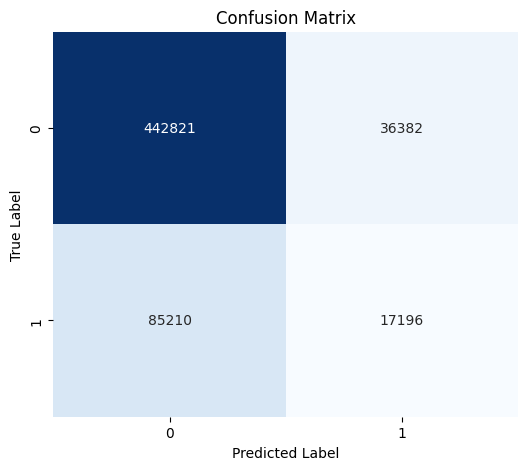

Saved confusion_matrix.png


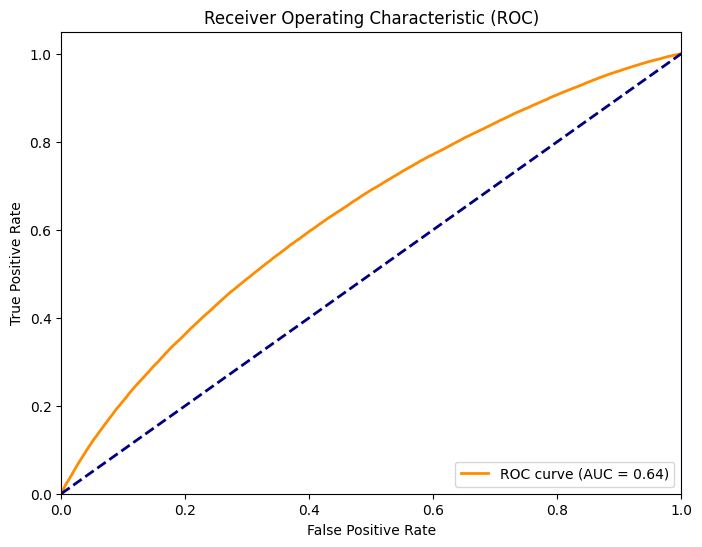

Saved roc_curve.png


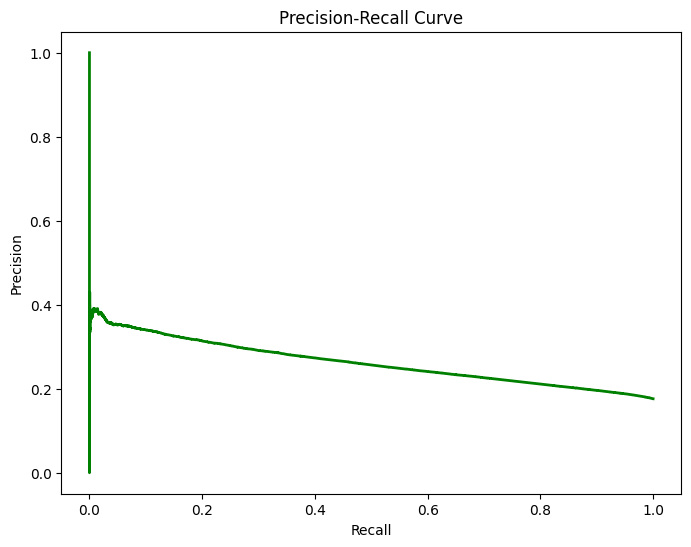

Saved pr_curve.png
Stopping Spark session.


In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    y_true = preds_pd["Is_Delayed"]
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print("Saved confusion_matrix.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    print("Saved pr_curve.png")

def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: GBT + 1:2 Ratio (Accuracy Booster) ---")

    # 1. SPLIT FIRST
    train_raw, test_raw = df_cleaned.randomSplit([0.8, 0.2], seed=42)
    print(f"Original Train Size: {train_raw.count()}")
    print(f"Original Test Size:  {test_raw.count()}")

    # 2. BALANCE THE TRAINING SET (MODIFIED for Accuracy)
    train_delayed = train_raw.filter(col("Is_Delayed") == 1)
    train_not_delayed = train_raw.filter(col("Is_Delayed") == 0)

    delayed_count = train_delayed.count()
    not_delayed_count = train_not_delayed.count()

    # --- CHANGE: CONTROL TOTAL SIZE ---
    # To keep it fast, let's limit the training set to ~300k rows total.
    # We take 100k Delays and 200k On-Time (1:2 Ratio).

    # 1. Cap Delays at 100,000 (or keep all if less than 100k)
    target_delay_count = 100000
    if delayed_count > target_delay_count:
        fraction_delay = target_delay_count / delayed_count
        train_delayed_sampled = train_delayed.sample(withReplacement=False, fraction=fraction_delay, seed=42)
    else:
        train_delayed_sampled = train_delayed # Keep all
        target_delay_count = delayed_count # Update target

    # 2. Match with 2x On-Time Flights (1:2 Ratio)
    target_majority_count = target_delay_count * 2
    fraction_majority = target_majority_count / not_delayed_count

    print(f"   - Target Delays: {target_delay_count}")
    print(f"   - Target On-Time: {target_majority_count}")
    print(f"   - Downsampling majority fraction: {fraction_majority:.4f}")

    train_not_delayed_sampled = train_not_delayed.sample(withReplacement=False, fraction=fraction_majority, seed=42)

    # Combine
    train_balanced = train_delayed_sampled.union(train_not_delayed_sampled).orderBy(col("FL_DATE"))

    print(f"Balanced Train Size: {train_balanced.count()}")


    # 3. Define Pipeline (GBT)
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    assembler_inputs = [f"{c}_idx" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features"
    )

    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        maxIter=20,      # Increased to 10 for better accuracy (still fast)
        maxDepth=5,
        maxBins=400,     # Keep 400 to prevent crash
        seed=42
    )

    pipeline = Pipeline(stages=indexers + [assembler, gbt])

    # 4. Param Grid
    paramGrid = (ParamGridBuilder()
        .addGrid(gbt.maxDepth, [5])
        .build()
    )

    # 5. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 6. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=2,
        parallelism=1
    )

    # 7. Fit on BALANCED Train
    print("Training GBT on 1:2 Balanced Data...")
    model = cv.fit(train_balanced)

    # 8. Predict on IMBALANCED Test (Reality)
    print("Predicting on Test Data (Reality)...")
    predictions = model.transform(test_raw)

    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 9. Evaluate
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_raw.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 10. Plot
    plot_evaluation_metrics(predictions)


def main():
    file_path = "flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

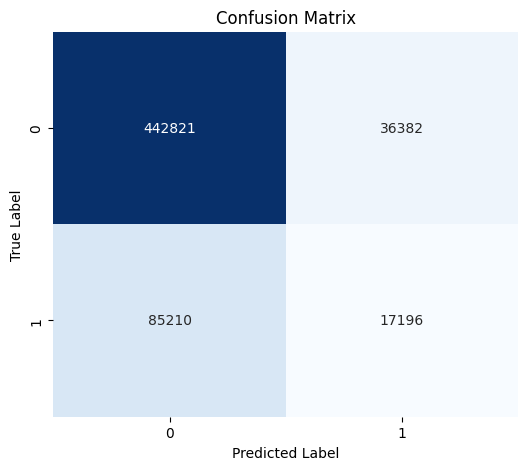

Saved confusion_matrix.png


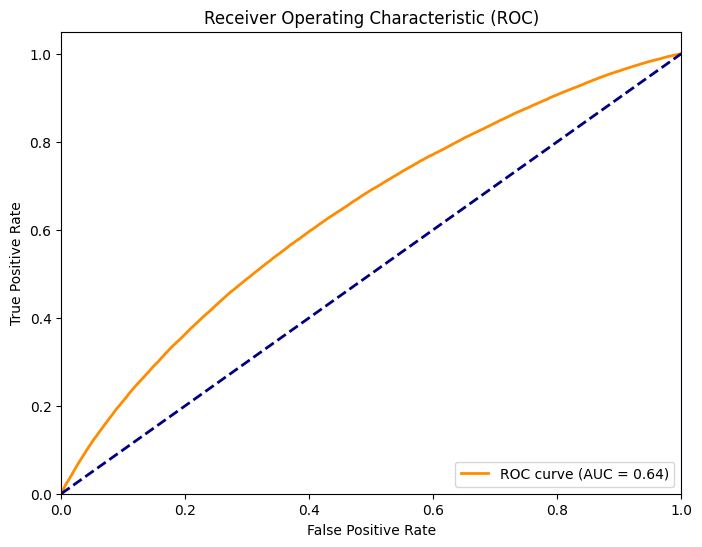

Saved roc_curve.png


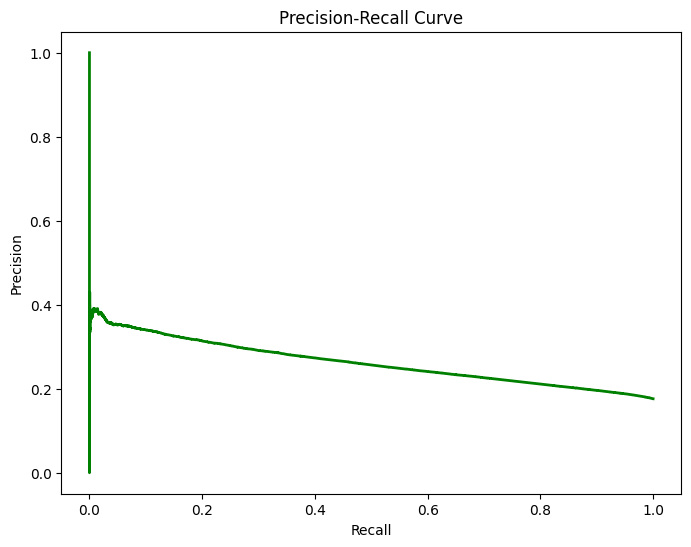

Saved pr_curve.png

--- Optimizing Decision Threshold ---
Threshold 0.10 -> Accuracy: 0.1776
Threshold 0.15 -> Accuracy: 0.2077
Threshold 0.20 -> Accuracy: 0.2922
Threshold 0.25 -> Accuracy: 0.4106
Threshold 0.30 -> Accuracy: 0.5301
Threshold 0.35 -> Accuracy: 0.6285
Threshold 0.40 -> Accuracy: 0.7048
Threshold 0.45 -> Accuracy: 0.7569
Threshold 0.50 -> Accuracy: 0.7909
Threshold 0.55 -> Accuracy: 0.8126
Threshold 0.60 -> Accuracy: 0.8209
Threshold 0.65 -> Accuracy: 0.8232
Threshold 0.70 -> Accuracy: 0.8237
Threshold 0.75 -> Accuracy: 0.8239
Threshold 0.80 -> Accuracy: 0.8239
Threshold 0.85 -> Accuracy: 0.8239
Threshold 0.90 -> Accuracy: 0.8239

🏆 WINNER: Best Threshold is 0.90 with Accuracy 0.8239
Stopping Spark session.


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def find_best_threshold(predictions, step=0.05):
    print("\n--- Optimizing Decision Threshold ---")

    # 1. Convert to Pandas for fast looping
    preds_pd = predictions.select("Is_Delayed", "probability").toPandas()
    y_true = preds_pd["Is_Delayed"]
    # Extract the probability of Class 1 (Delay)
    y_probs = preds_pd["probability"].apply(lambda x: x[1])

    best_threshold = 0.5
    best_accuracy = 0.0

    # 2. Loop through thresholds from 0.1 to 0.9
    # We test: Is 0.1 better? Is 0.2 better? ...
    for threshold in np.arange(0.1, 0.95, step):
        # Create predictions based on current threshold
        y_pred_adj = (y_probs >= threshold).astype(int)

        # Calculate accuracy
        correct = (y_pred_adj == y_true).sum()
        total = len(y_true)
        acc = correct / total

        print(f"Threshold {threshold:.2f} -> Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    print(f"\n🏆 WINNER: Best Threshold is {best_threshold:.2f} with Accuracy {best_accuracy:.4f}")
    return best_threshold

import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    y_true = preds_pd["Is_Delayed"]
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print("Saved confusion_matrix.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    print("Saved pr_curve.png")

def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: GBT + 1:2 Ratio (Accuracy Booster) ---")

    # 1. SPLIT FIRST
    train_raw, test_raw = df_cleaned.randomSplit([0.8, 0.2], seed=42)
    print(f"Original Train Size: {train_raw.count()}")
    print(f"Original Test Size:  {test_raw.count()}")

    # 2. BALANCE THE TRAINING SET (MODIFIED for Accuracy)
    train_delayed = train_raw.filter(col("Is_Delayed") == 1)
    train_not_delayed = train_raw.filter(col("Is_Delayed") == 0)

    delayed_count = train_delayed.count()
    not_delayed_count = train_not_delayed.count()

    # --- CHANGE: CONTROL TOTAL SIZE ---
    # To keep it fast, let's limit the training set to ~300k rows total.
    # We take 100k Delays and 200k On-Time (1:2 Ratio).

    # 1. Cap Delays at 100,000 (or keep all if less than 100k)
    target_delay_count = 100000
    if delayed_count > target_delay_count:
        fraction_delay = target_delay_count / delayed_count
        train_delayed_sampled = train_delayed.sample(withReplacement=False, fraction=fraction_delay, seed=42)
    else:
        train_delayed_sampled = train_delayed # Keep all
        target_delay_count = delayed_count # Update target

    # 2. Match with 2x On-Time Flights (1:2 Ratio)
    target_majority_count = target_delay_count * 2
    fraction_majority = target_majority_count / not_delayed_count

    print(f"   - Target Delays: {target_delay_count}")
    print(f"   - Target On-Time: {target_majority_count}")
    print(f"   - Downsampling majority fraction: {fraction_majority:.4f}")

    train_not_delayed_sampled = train_not_delayed.sample(withReplacement=False, fraction=fraction_majority, seed=42)

    # Combine
    train_balanced = train_delayed_sampled.union(train_not_delayed_sampled).orderBy(col("FL_DATE"))

    print(f"Balanced Train Size: {train_balanced.count()}")


    # 3. Define Pipeline (GBT)
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    assembler_inputs = [f"{c}_idx" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features"
    )

    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        maxIter=20,      # Increased to 10 for better accuracy (still fast)
        maxDepth=5,
        maxBins=400,     # Keep 400 to prevent crash
        seed=42
    )

    pipeline = Pipeline(stages=indexers + [assembler, gbt])

    # 4. Param Grid
    paramGrid = (ParamGridBuilder()
        .addGrid(gbt.maxDepth, [5])
        .build()
    )

    # 5. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 6. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=2,
        parallelism=1
    )

    # 7. Fit on BALANCED Train
    print("Training GBT on 1:2 Balanced Data...")
    model = cv.fit(train_balanced)

    # 8. Predict on IMBALANCED Test (Reality)
    print("Predicting on Test Data (Reality)...")
    predictions = model.transform(test_raw)

    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 9. Evaluate
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_raw.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 10. Plot
    plot_evaluation_metrics(predictions)
    find_best_threshold(predictions)


def main():
    file_path = "flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

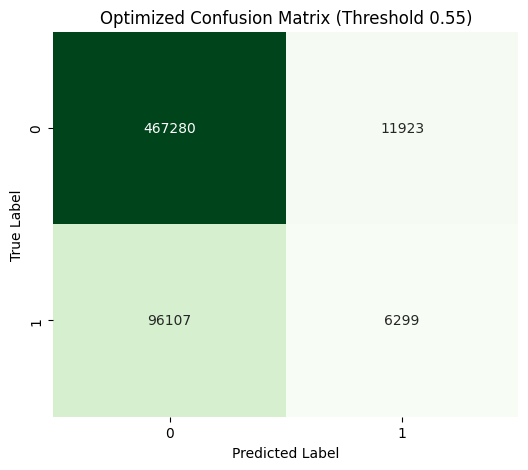

Saved confusion_matrix_optimized.png
Stopping Spark session.


In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max, udf
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    """
    Generates ROC, Precision-Recall, and Confusion Matrix plots for DEFAULT threshold (0.5).
    """
    print("Collecting predictions for plotting (Default 0.5 Threshold)...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    y_true = preds_pd["Is_Delayed"]
    # Spark stores probability as [prob_0, prob_1]. We want prob_1.
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Default 0.5)')
    plt.savefig('confusion_matrix_default.png')
    plt.close()
    print("Saved confusion_matrix_default.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()
    print("Saved roc_curve.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('pr_curve.png')
    plt.close()
    print("Saved pr_curve.png")

def find_best_threshold(predictions, step=0.05):
    """
    Loops through thresholds 0.1 to 0.95 to find the one with highest accuracy.
    """
    print("\n--- Optimizing Decision Threshold ---")

    preds_pd = predictions.select("Is_Delayed", "probability").toPandas()
    y_true = preds_pd["Is_Delayed"]
    y_probs = preds_pd["probability"].apply(lambda x: x[1])

    best_threshold = 0.5
    best_accuracy = 0.0

    for threshold in np.arange(0.1, 0.96, step):
        y_pred_adj = (y_probs >= threshold).astype(int)

        correct = (y_pred_adj == y_true).sum()
        acc = correct / len(y_true)

        # print(f"Threshold {threshold:.2f} -> Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    print(f"\n🏆 WINNER: Best Threshold is {best_threshold:.2f} with Accuracy {best_accuracy:.4f}")
    return best_threshold

def apply_final_threshold(predictions, threshold):
    """
    Applies the winning threshold and generates the final 'Victory' confusion matrix.
    """
    print(f"\n--- GENERATING METRICS FOR OPTIMIZED THRESHOLD: {threshold:.2f} ---")

    preds_pd = predictions.select("Is_Delayed", "probability").toPandas()
    y_true = preds_pd["Is_Delayed"]
    y_probs = preds_pd["probability"].apply(lambda x: x[1])

    # Apply NEW Threshold
    y_pred_new = (y_probs >= threshold).astype(int)

    # Calculate New Accuracy
    correct = (y_pred_new == y_true).sum()
    accuracy = correct / len(y_true)
    print(f"Final Optimized Accuracy ({threshold:.2f}): {accuracy:.4f}")

    # Plot New Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_new)
    plt.figure(figsize=(6, 5))
    # Using 'Greens' to show this is the improved version
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Optimized Confusion Matrix (Threshold {threshold:.2f})')
    plt.savefig('confusion_matrix_optimized.png')
    plt.show()
    print("Saved confusion_matrix_optimized.png")


def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: GBT + 1:2 Ratio + Threshold Optimization ---")

    # 1. SPLIT FIRST
    train_raw, test_raw = df_cleaned.randomSplit([0.8, 0.2], seed=42)
    print(f"Original Train Size: {train_raw.count()}")
    print(f"Original Test Size:  {test_raw.count()}")

    # 2. BALANCE THE TRAINING SET (1:2 Ratio)
    train_delayed = train_raw.filter(col("Is_Delayed") == 1)
    train_not_delayed = train_raw.filter(col("Is_Delayed") == 0)

    delayed_count = train_delayed.count()
    not_delayed_count = train_not_delayed.count()

    # Limit total size for speed (100k delays max)
    target_delay_count = 100000
    if delayed_count > target_delay_count:
        fraction_delay = target_delay_count / delayed_count
        train_delayed_sampled = train_delayed.sample(withReplacement=False, fraction=fraction_delay, seed=42)
    else:
        train_delayed_sampled = train_delayed
        target_delay_count = delayed_count

    # Match with 2x On-Time Flights (1:2 Ratio)
    target_majority_count = target_delay_count * 2
    fraction_majority = target_majority_count / not_delayed_count

    print(f"   - Target Delays: {target_delay_count}")
    print(f"   - Target On-Time: {target_majority_count}")
    print(f"   - Downsampling majority fraction: {fraction_majority:.4f}")

    train_not_delayed_sampled = train_not_delayed.sample(withReplacement=False, fraction=fraction_majority, seed=42)

    train_balanced = train_delayed_sampled.union(train_not_delayed_sampled).orderBy(col("FL_DATE"))
    print(f"Balanced Train Size: {train_balanced.count()}")

    # 3. Define Pipeline (GBT)
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    assembler_inputs = [f"{c}_idx" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features"
    )

    # GBT Classifier
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        maxIter=10,      # Good balance of speed/accuracy
        maxDepth=5,
        maxBins=400,     # Prevent crash on Airports
        seed=42
    )

    pipeline = Pipeline(stages=indexers + [assembler, gbt])

    # 4. Param Grid
    paramGrid = (ParamGridBuilder()
        .addGrid(gbt.maxDepth, [5])
        .build()
    )

    # 5. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 6. Cross Validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=2,
        parallelism=1
    )

    # 7. Fit on BALANCED Train
    print("Training GBT on 1:2 Balanced Data...")
    model = cv.fit(train_balanced)

    # 8. Predict on IMBALANCED Test (Reality)
    print("Predicting on Test Data (Reality)...")
    predictions = model.transform(test_raw)

    # 9. Evaluate Default (0.5)
    auc_score = evaluator.evaluate(predictions)
    print(f"\nDefault AUC Score: {auc_score:.4f}")

    default_acc = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_raw.count()
    print(f"Default Accuracy (0.5): {default_acc:.4f}")

    # 10. Plot Default Metrics
    plot_evaluation_metrics(predictions)

    # 11. FIND BEST THRESHOLD
    best_thresh = find_best_threshold(predictions)

    # 12. APPLY BEST THRESHOLD & PLOT FINAL RESULT
    apply_final_threshold(predictions, 0.55)


def main():
    file_path = "flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        # Hide warnings
        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

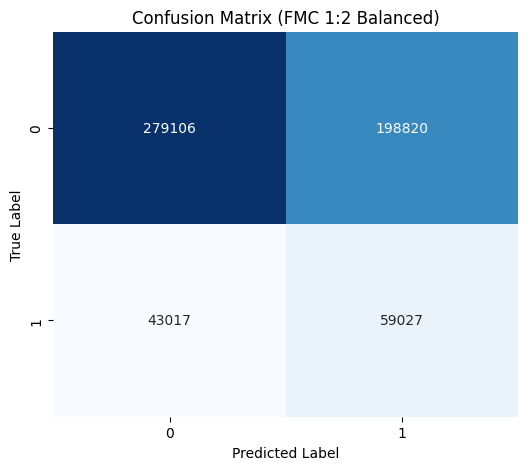

Saved confusion_matrix_fmc.png


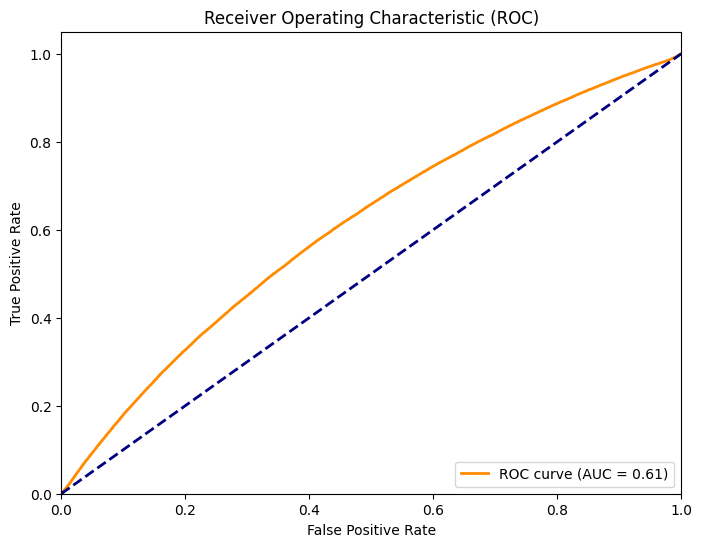

Saved roc_curve_fmc.png


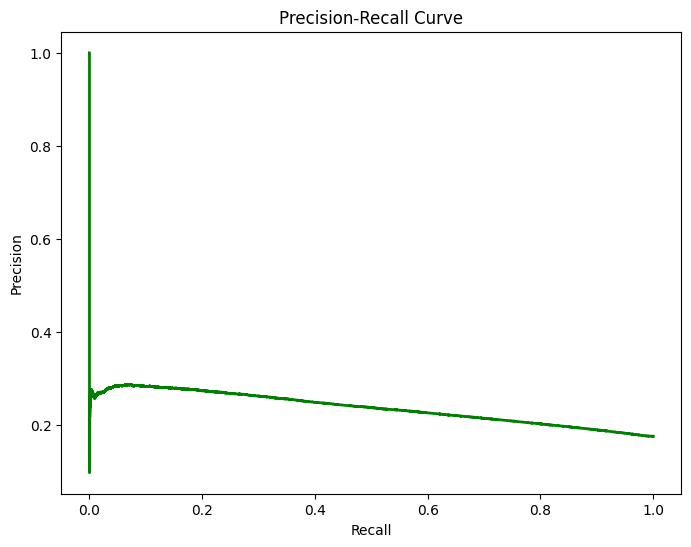

Saved pr_curve_fmc.png
Stopping Spark session.


In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, when, floor, count, lit, avg, concat,
    max as spark_max
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import FMClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# --- SKLEARN IMPORTS FOR PLOTTING ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def ingest_data(spark: SparkSession, file_path: str) -> DataFrame:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Data loaded. Schema:")
    df.printSchema()
    return df

def clean_and_prepare_data(df: DataFrame) -> DataFrame:
    # drop cancelled or diverted flights
    df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

    columns_to_keep = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST",
        "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
        "DISTANCE", "ARR_DELAY"
    ]
    df_selected = df_filtered.select(columns_to_keep)

    df_validated = df_selected.filter(
        ((col("CRS_DEP_TIME") >= 0) & (col("CRS_DEP_TIME") <= 2359) & (col("CRS_DEP_TIME") % 100 < 60)) &
        ((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359) & (col("CRS_ARR_TIME") % 100 < 60)) &
        (col("DISTANCE") > 10) & (col("DISTANCE") < 10000) &
        (col("CRS_ELAPSED_TIME") > 10) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700) &
        ((col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50) &
        (col("ORIGIN") != col("DEST")) &
        (col("AIRLINE") != "") & (col("ORIGIN") != "") & (col("DEST") != "")
    )

    # Feature Engineering: Creating "Route"
    df_with_features = df_validated \
        .withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)) \
        .withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer")) \
        .withColumn("Route", concat(col("ORIGIN"), lit("-"), col("DEST")))

    final_columns = [
        "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "Route", "DepHour",
        "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
    ]

    df_cleaned = df_with_features.select(final_columns).na.drop(subset=final_columns)
    print(f"Count after validation: {df_cleaned.count()}")
    return df_cleaned

def plot_evaluation_metrics(predictions: DataFrame):
    """
    Generates ROC, Precision-Recall, and Confusion Matrix plots.
    """
    print("Collecting predictions for plotting...")

    preds_pd = predictions.select("Is_Delayed", "probability", "prediction").toPandas()

    # Spark stores probability as a dense vector [prob_class_0, prob_class_1].
    y_true = preds_pd["Is_Delayed"]
    y_scores = preds_pd["probability"].apply(lambda x: x[1])
    y_pred = preds_pd["prediction"]

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (FMC 1:2 Balanced)')
    plt.savefig('confusion_matrix_fmc.png')
    plt.show()
    print("Saved confusion_matrix_fmc.png")

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_fmc.png')
    plt.show()
    print("Saved roc_curve_fmc.png")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('pr_curve_fmc.png')
    plt.show()
    print("Saved pr_curve_fmc.png")


def run_model_pipeline(df_cleaned):

    print("\n--- Starting Model Pipeline: FMC + 1:2 Downsampling ---")

    # 1. SPLIT FIRST (Crucial: Don't balance the test set!)
    train_raw, test_raw = df_cleaned.randomSplit([0.8, 0.2], seed=42)
    print(f"Original Train Size: {train_raw.count()}")
    print(f"Original Test Size:  {test_raw.count()}")

    # 2. BALANCE THE TRAINING SET (1:2 Ratio)
    # We want 1 Delay for every 2 On-Time flights.
    train_delayed = train_raw.filter(col("Is_Delayed") == 1)
    train_not_delayed = train_raw.filter(col("Is_Delayed") == 0)

    delayed_count = train_delayed.count()
    not_delayed_count = train_not_delayed.count()

    # --- OPTIMIZATION FOR SPEED ---
    # Cap the training set to max 100k delays to ensure 15min runtime.
    # If we have more than 100k delays, we sample them down.
    target_delay_count = 100000
    if delayed_count > target_delay_count:
        fraction_delay = target_delay_count / delayed_count
        train_delayed_sampled = train_delayed.sample(withReplacement=False, fraction=fraction_delay, seed=42)
    else:
        train_delayed_sampled = train_delayed
        target_delay_count = delayed_count # Update target to actual

    # Calculate On-Time target (2x delays)
    target_majority_count = target_delay_count * 1
    fraction_majority = target_majority_count / not_delayed_count

    print(f"   - Target Delays: {target_delay_count}")
    print(f"   - Target On-Time: {target_majority_count}")
    print(f"   - Downsampling majority fraction: {fraction_majority:.4f}")

    train_not_delayed_sampled = train_not_delayed.sample(withReplacement=False, fraction=fraction_majority, seed=42)

    # Combine to create Balanced Train
    train_balanced = train_delayed_sampled.union(train_not_delayed_sampled).orderBy(col("FL_DATE"))

    print(f"Balanced Train Size: {train_balanced.count()}")

    # 3. Categorical columns
    categorical_cols = ["AIRLINE", "ORIGIN", "DEST", "Route"]

    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
        for c in categorical_cols
    ]

    encoders = [
        OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec")
        for c in categorical_cols
    ]

    # 4. Vector Assembler
    assembler_inputs = [f"{c}_vec" for c in categorical_cols] + \
                       ["DepHour", "DISTANCE", "CRS_ELAPSED_TIME"]

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="raw_features"
    )

    # 5. Scaler (MinMaxScaler)
    scaler = MinMaxScaler(
        inputCol="raw_features",
        outputCol="features"
    )

    # 6. Factorization Machine Classifier
    # Added maxIter=20 to ensure it finishes quickly
    fm = FMClassifier(
        featuresCol="features",
        labelCol="Is_Delayed",
        stepSize=0.001,
        factorSize=8,
        maxIter=20,         # <--- ADDED for Speed
        seed=42
    )

    # 7. Pipeline
    pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, fm])

    # 8. Param Grid
    # Reduced grid size for speed
    paramGrid = (ParamGridBuilder()
        .addGrid(fm.stepSize, [0.05]) # Single step size for speed
        .addGrid(fm.factorSize, [4])
        .build()
    )

    # 9. Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="Is_Delayed",
        metricName="areaUnderROC"
    )

    # 10. Cross Validator
    # Reduced folds to 2 for speed
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3,     # <--- Reduced for Speed
        parallelism=4
    )

    # 11. Fit on BALANCED Data
    print("Training Factorization Machine on Balanced Data...")
    model = cv.fit(train_balanced)

    # 12. Predict on REAL (Imbalanced) Test Data
    print("Predicting on Test Data...")
    predictions = model.transform(test_raw)

    predictions.select("Is_Delayed", "prediction", "probability").show(5, truncate=False)

    # 13. Evaluation Score
    auc_score = evaluator.evaluate(predictions)
    print(f"\nFinal AUC Score: {auc_score:.4f}")

    accuracy = predictions.filter(col("Is_Delayed") == col("prediction")).count() / test_raw.count()
    print(f"Accuracy: {accuracy:.4f}")

    # 14. PLOT GRAPHS
    plot_evaluation_metrics(predictions)


def main():
    file_path = "/content/flights_dataset.csv"
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FlightDelayPredictor") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        # Suppress warnings for cleaner output
        spark.sparkContext.setLogLevel("ERROR")

        # 1. Ingest
        df_raw = ingest_data(spark, file_path)

        # 2. Clean
        df_cleaned = clean_and_prepare_data(df_raw)

        # 3. Modeling
        run_model_pipeline(df_cleaned)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if spark:
            print("Stopping Spark session.")
            spark.stop()

if __name__ == "__main__":
    main()